In [1]:
import cv2
import os
import subprocess
from astropy.io import fits,ascii
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.table import Table
import multiprocessing
from astropy.table import Table
import numpy as np

In [2]:
#os.chdir("/home/alam/task/task-inspecity/source-ex")

(1024, 1024)


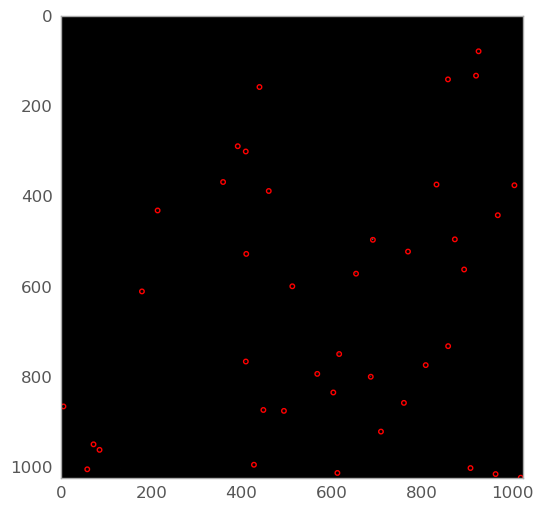

In [2]:
sext1 = ascii.read('/home/alam/task/task-inspecity/source-ex/test.cat',format = 'sextractor')
sext1.sort(['MAG_ISO'])
sext2 = sext1[0:40]
sextx = sext2['X_IMAGE']
sexty = sext2['Y_IMAGE']
sex_mag = sext2['MAG_ISO']
sext_x = (sextx-512)*0.0027 

sext_y = (sexty-512)*0.0027
#hdul = fits.open('/home/alam/task/task-inspecity/source-ex/img-0001.fits')
#image_data = hdul[0].data



image_data = fits.getdata('/home/alam/task/task-inspecity/source-ex/img_fits.fits',ext = 0)
print(image_data.shape)
plt.figure()
plt.imshow(image_data,cmap = 'gray')
plt.grid(False)

for x_coord, y_coord in zip(sextx, sexty):
    circle = plt.Circle((x_coord, y_coord), radius=5, color='r', fill=False)
    plt.gca().add_patch(circle)

plt.show()


(1024, 1024)


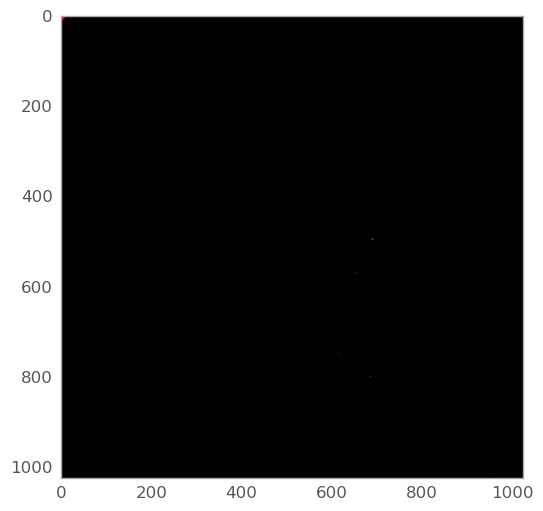

In [3]:
x_coords = []
y_coords = []
with open('/home/alam/task/task-inspecity/star_tracker/Star_Tracker/RPI/sext_t', 'r') as file:
        for line in file:
            # Split the line into x and y coordinates
            x, y,_ = map(float, line.split())
            x_coords.append(x)
            y_coords.append(y)




image_data = fits.getdata('/home/alam/task/task-inspecity/source-ex/img_fits.fits',ext = 0)
print(image_data.shape)
plt.figure()
plt.imshow(image_data,cmap = 'gray')
plt.grid(False)

for x_coord, y_coord in zip(x_coords, y_coords):
    circle = plt.Circle((x_coord, y_coord), radius=5, color='r', fill=False)
    plt.gca().add_patch(circle)

plt.show()

In [4]:
x_coords_n = []
y_coords_n = []
with open('/home/alam/task/task-inspecity/sex_t', 'r') as file:
        for line in file:
            # Split the line into x and y coordinates
            x, y,_ = map(float, line.split())
            x_coords_n.append(x)
            y_coords_n.append(y)

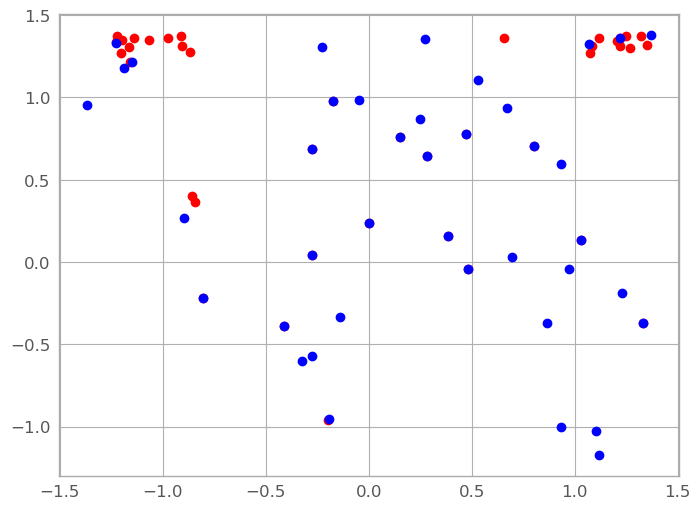

In [5]:
plt.scatter(x_coords,y_coords,color = 'r')
plt.scatter(x_coords_n,y_coords_n,color = 'b')

In [17]:
sext1

X_IMAGE,Y_IMAGE,MAG_ISO
pix,pix,mag
float64,float64,float64
691.1735,496.3013,-7.4658
686.4218,799.8023,-6.4832
653.8292,571.3306,-6.458
616.4156,749.454,-6.0904
567.867,793.4402,-5.6014
409.5101,766.0656,-5.2932
1004.8326,375.4149,-5.1705
214.0,431.2519,-5.0321


In [6]:
ascii.write([sext_x, sext_y, sex_mag], '/home/alam/task/task-inspecity/sex_t', delimiter = ' ', format = 'no_header',overwrite=True, formats = {'col0':'% 15.10f', 'col1':'% 15.10f', 'col2':'% 15.10f'})

In [18]:
ra_dec = [(ra, dec) for ra in range(0, 360, 5) for dec in range(-80, 90, 5)]

def call_match(ra_dec):
    RA1, DEC1 = ra_dec
    # Transform RA and DEC in string and make the path for catalog.
    path_catalog1 = '/home/alam/task/task-inspecity/star_tracker/Star_Tracker/RPI/Catalog/Projected' +  '/cat_RA_'
    path_catalog2 = str(RA1) + '_DEC_' + str(DEC1)
    path_catalog3 = path_catalog1 + path_catalog2
    # Do Match.
    parameters1 = 'matchrad = 1 trirad = 0.002 nobj = 15 scale = 1'
    command = 'match' + '/home/alam/task/task-inspecity/sex_t' + ' 0 1 2 ' + path_catalog3 + ' 0 1 2 ' + parameters1
    
    results = subprocess.run(command, shell=True, capture_output=True, text=True)
    stdout_str = results.stdout
    return stdout_str

pool = multiprocessing.Pool(2)
results = pool.map(call_match, ra_dec)

In [19]:
results

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [11]:
match1_table1 = Table(names=('RA_center', 'DEC_center', 'sig', 'Nr'))


In [12]:
for i, item in enumerate(results):
    RA1, DEC1 = ra_dec[i]
    
    
    match1_aux1 = item.find('sig=')
    match1_aux2 = item.find('Nr=')
    match1_auxsig1 = item[match1_aux1+4:match1_aux1+25]
    match1_auxnr1 = item[match1_aux2+3:match1_aux2+10]
    match1_sig1 = match1_auxsig1.split(' ', 1)[0]
    match1_nr1 = match1_auxnr1.split(' ', 1)[0]
    if match1_sig1 and match1_nr1:  # Check if both 'sig' and 'Nr' values are non-empty
            match1_table1.add_row([str(RA1), str(DEC1), match1_sig1, match1_nr1])

In [13]:
match1_table1.sort('Nr',reverse=True)

In [14]:
match1_table1

RA_center,DEC_center,sig,Nr
float64,float64,float64,float64


In [13]:
if len(match1_table1) >= 3:
        a = match1_table1[0]['sig']
        b = match1_table1[1]['sig']
        c = match1_table1[2]['sig']
        if a <= b:
            if a <= c:
                i = 0
            else:
                i = 2
        else:
            if b <= c:
                i = 1
            else:
                i = 2

In [14]:
match1_RA = int(match1_table1[i][0])
match1_DEC = int(match1_table1[i][1])
path_catalog1 = '/home/alam/task/task-inspecity/star_tracker/Star_Tracker/RPI/Catalog/Projected' +  '/cat_RA_'
path_catalog6 = str(match1_RA) + '_DEC_' + str(match1_DEC)
path_catalog7 = path_catalog1 + path_catalog6
parameters1 = 'matchrad=1.0 trirad=0.002 nobj=15'
Match2 = 'match ' + '/home/alam/task/task-inspecity/sex_t' + ' 0 1 2 ' + path_catalog7 + ' 0 1 2 ' + parameters1
results = subprocess.run(Match2, shell=True, capture_output=True, text=True)
stdout_str = results.stdout
stdout_str

'TRANS: a=7.913167641e-01 b=2.227298997e-01 c=1.168243897e+00 d=-4.292000355e-01 e=1.024417848e+00 f=-3.199392400e-01 sig=5.5457e-02 Nr=27 Nm=27 sx=2.0706e-01 sy=1.5022e-01 \n'

In [15]:
match1_RA

40

In [16]:
match1_aux5 = stdout_str.find('a=')
match1_aux6 = stdout_str.find('b=')
match1_aux7 = stdout_str.find('c=')
match1_aux8 = stdout_str.find('d=')
match1_aux9 = stdout_str.find('e=')
match1_aux10 = stdout_str.find('f=')
match1_aux11 = stdout_str.find('sig=')
match1_aux12 = stdout_str.find('Nr=')
match1_aux13 = stdout_str.find('Nm=')
match1_auxa1 = stdout_str[match1_aux5+2:match1_aux5+25]
match1_auxb1 = stdout_str[match1_aux6+2:match1_aux6+25]
match1_auxc1 = stdout_str[match1_aux7+2:match1_aux7+25]
match1_auxd1 = stdout_str[match1_aux8+2:match1_aux8+25]
match1_auxe1 = stdout_str[match1_aux9+2:match1_aux9+25]
match1_auxf1 = stdout_str[match1_aux10+2:match1_aux10+25]
match1_auxsig3 = stdout_str[match1_aux11+4:match1_aux11+25]
match1_auxnr3 = stdout_str[match1_aux12+3:match1_aux12+10]
match1_auxnm3 = stdout_str[match1_aux13+3:match1_aux13+10]
match1_sig3 = match1_auxsig3.split(' ', 1)[0]
match1_nr3 = match1_auxnr3.split(' ', 1)[0]
match1_nm3 = match1_auxnm3.split(' ', 1)[0]
match1_auxa2 = match1_auxa1.split(' ', 1)[0]
match1_auxb2 = match1_auxb1.split(' ', 1)[0]
match1_auxc2 = match1_auxc1.split(' ', 1)[0]
match1_auxd2 = match1_auxd1.split(' ', 1)[0]
match1_auxe2 = match1_auxe1.split(' ', 1)[0]
match1_auxf2 = match1_auxf1.split(' ', 1)[0]
match1_a = float(match1_auxa2)
match1_b = float(match1_auxb2)
match1_c = float(match1_auxc2)
match1_d = float(match1_auxd2)
match1_e = float(match1_auxe2)
match1_f = float(match1_auxf2)

In [17]:
match1_a

0.7913167641

In [18]:
match1_T = np.array([(match1_a), (match1_d)])
match1_R = np.array([(match1_b, match1_c), (match1_e, match1_f)])

In [19]:
match1_T

array([ 0.79131676, -0.42920004])

In [20]:
match1_R

array([[ 0.2227299 ,  1.1682439 ],
       [ 1.02441785, -0.31993924]])

In [21]:
match1_x_pix = 0
match1_y_pix = 0
match1_X_pix = np.array([(match1_x_pix), (match1_y_pix)])
match1_X_cielo = match1_T + np.dot(match1_R, match1_X_pix)
match1_RA_new = match1_X_cielo[0]
match1_DEC_new = match1_X_cielo[1]
match1_roll_r = np.arctan2(match1_c, match1_b)
match1_roll_d = (180/np.pi)*match1_roll_r

In [22]:
f = 3.04 #mm
dep1_xi = match1_RA_new/f
dep1_eta = match1_DEC_new/f
dep1_RA_r = match1_RA*(np.pi/180)
dep1_DEC_r = match1_DEC*(np.pi/180)
dep1_arg1 = np.cos(dep1_DEC_r) - dep1_eta*np.sin(dep1_DEC_r)
dep1_arg2 = np.arctan(dep1_xi/dep1_arg1)
dep1_alpha1 = match1_RA + (180/np.pi)*dep1_arg2
dep1_arg3 = np.sin(dep1_arg2)
dep1_arg4 = dep1_eta*np.cos(dep1_DEC_r) + np.sin(dep1_DEC_r)
dep1_delta1 = (180/np.pi)*np.arctan((dep1_arg3*dep1_arg4)/dep1_xi)

In [31]:
print(dep1_alpha1)
print(dep1_delta1)

56.12889386818626
26.045082764267082


In [23]:
cat_nor = '/home/alam/task/task-inspecity/star_tracker/Star_Tracker/RPI/Catalog/Normal/'
new_cat1 = cat_nor + 'cat_RA_' + str(match1_RA) + '_DEC_' + str(match1_DEC)
new_cat2 = ascii.read(new_cat1)
np_matched_B1 = ascii.read('/home/alam/task/task-inspecity/notebooks/matched.mtB')
np_matched_B2 = ascii.read('/home/alam/task/task-inspecity/notebooks/matched.unB')
np_aux1 = np_matched_B1[0][0]
np_aux2 = np_matched_B2[0][0]

if np_aux1>np_aux2:
    np_cont1 = np_aux2
else:
    np_cont1 = np_aux1

np_table1 = Table([[], [], []])

for i in range(0, len(np_matched_B1), 1):
    np_cont2 = np_matched_B1[i][0] - np_cont1
    np_table1.add_row([new_cat2[np_cont2][0], new_cat2[np_cont2][1], new_cat2[np_cont2][2]])

In [24]:

new_cat2 = ascii.read('/home/alam/task/task-inspecity/sex_t')
np_matched_A1 = ascii.read('/home/alam/task/task-inspecity/notebooks/matched.mtA')
np_table2 = Table([[], [], []])
for i in range(0, len(np_matched_A1), 1):
    np_cont2 = np_matched_A1[i][0]
    np_table2.add_row([new_cat2[np_cont2][0], new_cat2[np_cont2][1], new_cat2[np_cont2][2]])

In [25]:
np_table2

col0,col1,col2
float64,float64,float64
-0.898425,-0.26639982000000006,-3.4507
-0.80467857,0.21793967999999994,-5.0321
-0.4126968900000001,0.3883164299999999,-4.5652
-1.1529010800000001,-1.2145847399999998,-2.7852
-0.3249817200000001,0.6023454299999998,-2.6036
-0.19496835000000007,0.9567946800000002,-3.9495
-0.27699542999999993,0.5711728499999998,-3.3561
-0.13945824000000007,0.33448598999999996,-4.0837
-0.27418959,-0.04198958999999995,-4.4086


In [26]:
cat_tran1 = Table([[], [], []])
conv1_largo1 = len(np_table1)

for index in range (0, conv1_largo1):
    conv1_alpha_d = np_table1[index][0]
    conv1_delta_d = np_table1[index][1]
    conv1_mag = np_table1[index][2]
    
    conv1_alpha_r = (np.pi/180)*conv1_alpha_d
    conv1_delta_r = (np.pi/180)*conv1_delta_d
    conv1_alpha_0_r = (np.pi/180)*dep1_alpha1
    conv1_delta_0_r = (np.pi/180)*dep1_delta1
    
    conv1_xi_up = np.cos(conv1_delta_r)*np.sin(conv1_alpha_r - conv1_alpha_0_r)
    conv1_xi_down = np.sin(conv1_delta_0_r)*np.sin(conv1_delta_r) + np.cos(conv1_delta_0_r)*np.cos(conv1_delta_r)*np.cos(conv1_alpha_r - conv1_alpha_0_r)
    conv1_xi = conv1_xi_up/conv1_xi_down
    
    conv1_eta_up = np.cos(conv1_delta_0_r)*np.sin(conv1_delta_r) - np.sin(conv1_delta_0_r)*np.cos(conv1_delta_r)*np.cos(conv1_alpha_r - conv1_alpha_0_r)
    conv1_eta_down = conv1_xi_down
    conv1_eta = conv1_eta_up/conv1_eta_down
    
    conv1_xi_mm = f*conv1_xi
    conv1_eta_mm = f*conv1_eta
    
    cat_tran1.add_row([conv1_xi_mm, conv1_eta_mm, conv1_mag])

In [27]:
cat_tran1

col0,col1,col2
float64,float64,float64
-0.2705135681894118,-0.9284513400284511,3.6
-0.23667995283707008,-0.888088448714957,3.74
0.21564168966318364,-0.731222937978678,3.47
-1.9123589115192998,-0.42054582649817174,3.62
0.4611862264264425,-0.5491676378419523,3.65
0.6720643799489887,-0.4888711345352385,0.85
0.4950269982666313,-0.4417961499646939,3.76
0.05631652852593332,-0.10548821162676122,3.63
0.004354040814962027,-0.10253241449487911,3.7


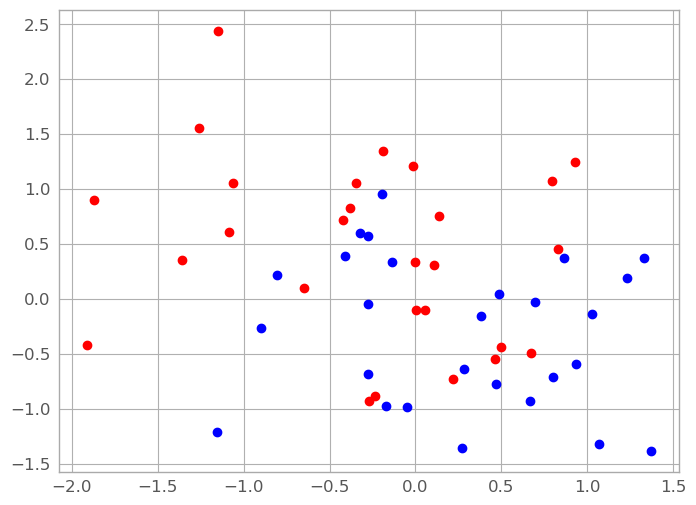

In [28]:
plt.scatter(cat_tran1['col0'], cat_tran1['col1'], color = 'r')
coordinates_mat = []
plt.scatter(np_table2['col0'], np_table2['col1'], color = 'b')


In [32]:
ascii.write(cat_tran1, 'new_cat', delimiter = ' ', format = 'no_header', formats = {'col0':'% 15.5f', 'col1':'% 15.5f', 'col2':'% 15.2f'})

In [37]:
new_parameters1 = 'trirad=0.002 nobj=20 max_iter=3 matchrad=1 scale=1'
Match4 = 'match ' + '/home/alam/task/task-inspecity/sex_t' + ' 0 1 2 ' + '/home/alam/task/task-inspecity/notebooks/new_cat' + ' 0 1 2 ' + new_parameters1
result_2 = subprocess.run(Match4, shell=True, capture_output=True, text=True)
stdout_str = result_2.stdout
stdout_str

''

In [38]:
result_2

CompletedProcess(args='match /home/alam/task/task-inspecity/sex_t 0 1 2 /home/alam/task/task-inspecity/notebooks/new_cat 0 1 2 trirad=0.002 nobj=20 max_iter=3 matchrad=1 scale=1', returncode=1, stdout='', stderr='atFindTrans: iter_trans unable to create a valid TRANS\ninitial call to atFindTrans fails\n')

In [30]:
coordinates_mat


[(0.075629, -1.1926487),
 (0.6597975, -1.2579021),
 (0.9981227, -0.9166519),
 (-1.0942414, -1.1368809),
 (1.2733929, -0.898528),
 (1.7236199, -0.8839844),
 (1.2557825, -0.8395259),
 (1.0381503, -0.621633),
 (0.5611888, -0.6336704),
 (-0.1703046, -0.4230813),
 (-0.4605015, -0.2205167),
 (0.9373509, 0.1073322),
 (0.6702202, 0.0721083),
 (1.4534155, 0.3839275),
 (-0.4209896, -0.0938215),
 (-0.7238781, 0.3539558),
 (0.0872284, 0.128857),
 (0.0029612, 0.3655969),
 (0.9352384, 0.3438139),
 (-0.1011508, 0.6187825),
 (1.3810052, 0.8168234),
 (0.2035483, 0.6763165),
 (1.6209966, 0.8584534),
 (0.937701, 0.7201321),
 (-0.3959893, 1.1523073),
 (0.3819605, 0.774774),
 (-0.3503346, 1.4767766)]